<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°; 45°; 135°; 225°; and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



## Basic definitions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import wind
import windBLWT as wt
import windCAD

import winsound

from typing import List,Literal,Dict,Tuple,Any,Union,Set


### Files and directories

In [3]:
# Directories
rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/multispan/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"

if not os.path.exists(outputDir):
    os.makedirs(outputDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)


### General parameters

In [4]:
saveFigs = True
exposure = "E2"
cases = ['c3','c4','c5','c6','c7']
caseSymbol = ['x-','x--','-x-','x---','-x--']

caseNames = [f"nrcNB{c}{exposure}" for c in cases]
casedirs = [rawHFPIdir+caseName+r"/" for caseName in caseNames]
print(caseNames)

profileDir = rawVelDir 

['nrcNBc3E2', 'nrcNBc4E2', 'nrcNBc5E2', 'nrcNBc6E2', 'nrcNBc7E2']


### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

## Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [5]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
roofSlope = 26.1  # roof slope

lScl=1/100.0
vScl=1/2.78
tScl=lScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

badTaps = []

### Basics of faces

In [6]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]


### Zone dictionary

In [7]:
zoneDict_basic = [
        {   # Face 1
            0:["NBCC 2020", "Zone c", np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:["NBCC 2020", "Zone c", np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:["NBCC 2020", "Zone c", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:["NBCC 2020", "Zone c", np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:["NBCC 2020", "Zone s'", np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:["NBCC 2020", "Zone s'", np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:["NBCC 2020", "Zone s'", np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:["NBCC 2020", "Zone s'", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:["NBCC 2020", "Zone s", np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:["NBCC 2020", "Zone s", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:["NBCC 2020", "Zone r", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        },
        {   # Face 2
            0:["NBCC 2020", "Zone c", np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:["NBCC 2020", "Zone c", np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:["NBCC 2020", "Zone c", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:["NBCC 2020", "Zone c", np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:["NBCC 2020", "Zone s'", np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:["NBCC 2020", "Zone s'", np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:["NBCC 2020", "Zone s'", np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:["NBCC 2020", "Zone s'", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:["NBCC 2020", "Zone s", np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:["NBCC 2020", "Zone s", np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:["NBCC 2020", "Zone r", np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        },
        {   # Face 3
            0:["NBCC 2020", "Zone e", np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:["NBCC 2020", "Zone e", np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:["NBCC 2020", "Zone w", np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 4
            0:["NBCC 2020", "Zone e", np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:["NBCC 2020", "Zone e", np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:["NBCC 2020", "Zone w", np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
        {   # Face 5
            0:["NBCC 2020", "Zone e", np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:["NBCC 2020", "Zone e", np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:["NBCC 2020", "Zone w", np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 6
            0:["NBCC 2020", "Zone e", np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:["NBCC 2020", "Zone e", np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:["NBCC 2020", "Zone w", np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
]

### Face objects

In [8]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    fc = windCAD.face(
                name=f'Face {z} ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Processing face 1...
Generating panels ...
Reached the limit of wiggle factor of 1.5. Breaking the loop.
Reached the limit of wiggle factor of 1.5. Breaking the loop.
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s'": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3

### Building objects

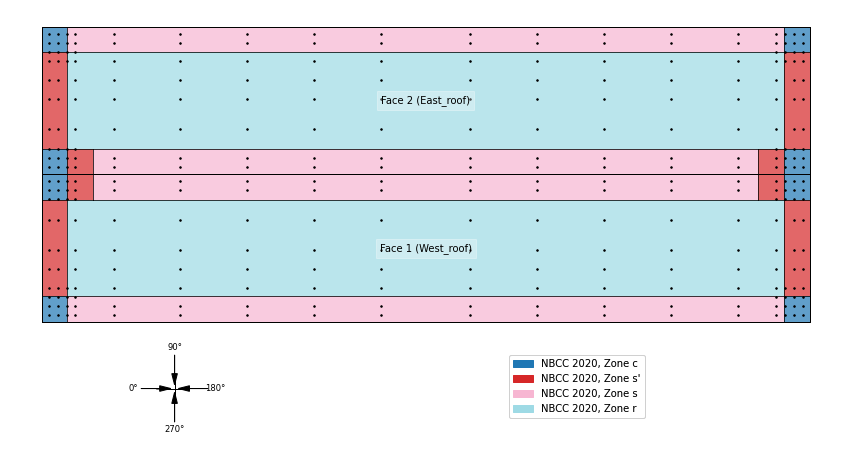

In [87]:
bldg = wind.bldgCp(bldgName='with all faces',
                # faces=faces,
                faces=[faces[0], faces[1]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName='Case 1 [x]',
                notes_Cp='Generic isolated case.',
                badTaps=badTaps,
                )

fig = plt.figure(figsize=[15,8])
ax = fig.subplots(1,1)

bldg.plotEdges(ax=ax,showName=True)
bldg.plotTaps(ax=ax,showTapNo=False)
_, legend, _ = bldg.plotZones(ax=ax)
ax.add_artist(legend)
# legend.set_bbox_to_anchor((0.81, 0.3))
# bldg.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
legend.set_bbox_to_anchor((0.6, 0.2))
bldg.plotAoA_definition(ax=ax, size=0.7, marginFactor=[4.0,-3.5])
ax.axis('equal')
ax.axis('off')

# if saveFigs:
#     fig.savefig(figDir+"tapLayout_withWalls.svg",format='svg',dpi=1200, bbox_inches='tight')
if saveFigs:
    fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')

In [14]:
bldgs: List[wind.bldgCp] = []
faceCombos = [[0,1], # case 3
              [0,1], # case 4
              [0,1], # case 5
              [0,1], # case 6
              [0,1], # case 7
              ]

for i,caseName in enumerate(caseNames):
    print(f"Processing case {caseName}...")
    fcs = [faces[j] for j in faceCombos[i]]

    bldgs.append(wind.bldgCp(bldgName=caseName,
                faces=fcs,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName=f"Case {i+3} [{caseSymbol[i]}]",
                notes_Cp='Generic isolated case.',
                badTaps=badTaps,
                ))

Processing case nrcNBc3E2...
Processing case nrcNBc4E2...
Processing case nrcNBc5E2...
Processing case nrcNBc6E2...
Processing case nrcNBc7E2...


### Geometry plots

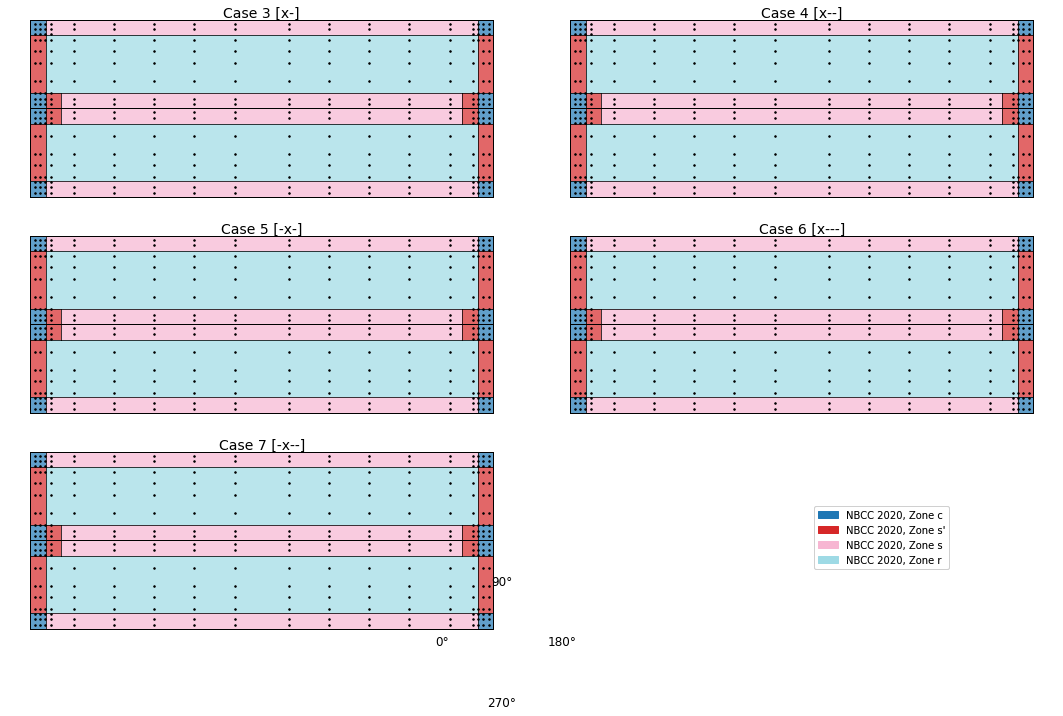

In [15]:
fig = plt.figure(figsize=[15,9])
axs = fig.subplots(3,2)
axs = axs.flatten()
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for i,bldg in enumerate(bldgs):
    ax = axs[i]
    ax.text(0.5, 0.95, bldg.name, transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
    bldg.plotEdges(ax=ax,showName=False)
    bldg.plotTaps(ax=ax,showTapNo=False)
    if i==0:
        _, legend, patches = bldg.plotZones(ax=ax,showLegend=False)
    else:
        bldg.plotZones(ax=ax, showLegend=False)
    ax.axis('equal')
    ax.axis('off')

ax = axs[-1]
bldgs[0].plotAoA_definition(ax=ax, size=1, marginFactor=[1.0,0.5])
ax.axis('equal')
fctr = 1.8
xshift = 300
yshift = 100
ax.set_xlim(ax.get_xlim()[0]*fctr+xshift, ax.get_xlim()[1]*fctr+xshift)
ax.set_ylim(ax.get_ylim()[0]*fctr+yshift, ax.get_ylim()[1]*fctr+yshift)

legend = ax.legend(handles=patches, bbox_to_anchor=(0.8, 0.7))
ax.add_artist(legend)
ax.axis('off')

plt.show()

if saveFigs:
    fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')


## Wind field

### Exposure conditions

Tunnel configurations for the considered exposures

### Read data

In [16]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [17]:
# if exp == 'E2':
#     vel_WT = vel_OP
# elif exp == 'E3':
#     vel_WT = vel_SU
z0_OP = 0.02
z0_OP = 0.2

es85 = wind.ESDU85(z0=0.02, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.02, Zref=H/lScl, Uref=25.0)
vel_E2_ESDU = es85.toProfileObj()
vel_E2_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0=0.02m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0=0.02m$)'

es85 = wind.ESDU85(z0=0.2, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.2, Zref=H/lScl, Uref=25.0)
vel_E3_ESDU = es85.toProfileObj()
vel_E3_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0=0.2m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0=0.2m$)'

vel = wind.Profiles([vel_OP, vel_E2_ESDU, vel_SU, vel_E3_ESDU])

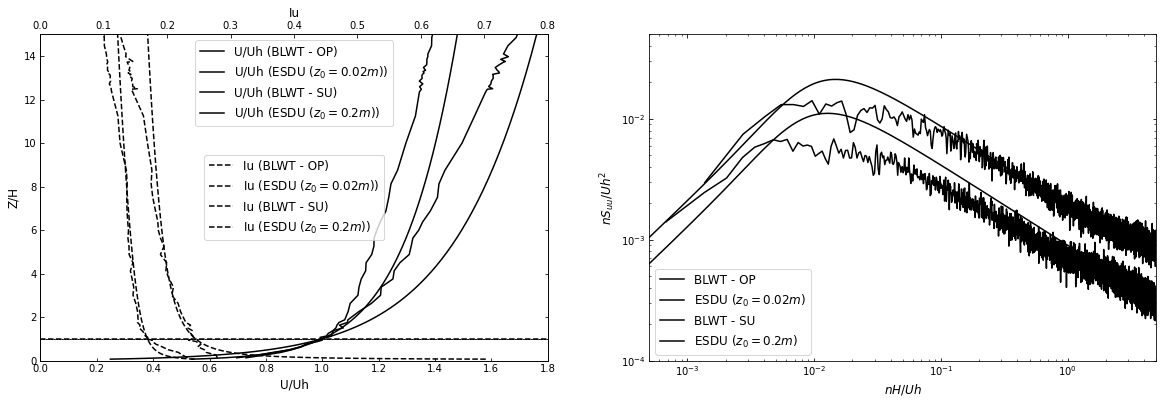

In [18]:
# print(np.shape(vel_OP.UofT))

# vStat = wind.get_velTH_stats(UofT=vel_OP.UofT, VofT=vel_OP.VofT, WofT=vel_OP.WofT,
#                              dt=vel_OP.dt, fields=wind.VALID_VELOCITY_STAT_FIELDS)

# kwargs = {}

# for k in vStat:
#     # print(np.shape(vStat[k]))
#     plt.figure()
#     plt.plot(vStat[k], vel_OP.Z, **kwargs)
#     plt.title(k)

# vel_OP.plotProfile_any('uw')
# vel_OP.plotProfile_basic1(figsize=[7,5], ylim=[0,5], U_lim=[0, 1.6], Iu_lim=[0, 0.8], )
# fig = vel_OP.plotProfile_basic2(ylim=[0,5], uw_lim=[0, 0.01], kwargs={'color': 'k', 'linestyle': '-'},)

# print(vel_OP.SpectH)
# fig = plt.figure(figsize=[6,6])
# ax = fig.add_subplot()
# vel_OP.SpectH.plotSpectra(fig=fig, axs=[ax,ax,ax], normalize=True, xLabel=r'$nH/Uh$', yLabel=r'$\frac{1}{n}\frac{dP}{d\ln(nH/Uh)}$')

vel.plot(
            figsize=[20,6], landscape=True,
            # figsize=[10,15], landscape=False,
            kwargs_profile={
                            'yLimits': [0,15], 
                            'xLimits_U': [0, 1.8], 
                            'xLimits_Iu': [0, 0.8],
                            # 'kwargs_U': {'color': 'k', 'linestyle': '-'},
                            # 'kwargs_Iu': {'color': 'k', 'linestyle': '--'},
                            # 'kwargs_legend_U': {'fontsize': 12, 'loc': 'upper center'},
                            # 'kwargs_ax': {'gridMajor':True, 'gridMinor':True}
                            }, 
            kwargs_spect={
                            'yLimits':[1e-4, 5e-2],
                            'xLimits': [5e-4, 5],
                            # 'kwargs_legend': {'fontsize': 12, 'loc': 'lower left'},
                            'kwargs_ax': {'gridMajor':True, 'gridMinor':True}
                            },)

### Plot wind field

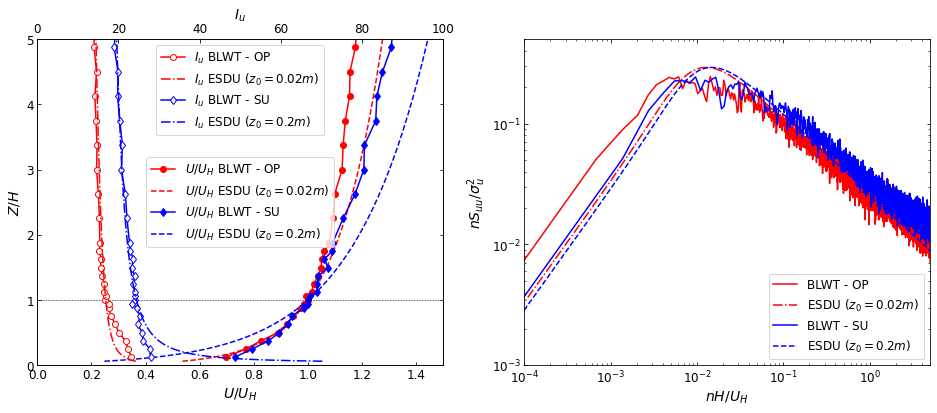

In [19]:
fig = vel.plot__(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
# if saveFigs:
#     fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

## Surface pressure, $C_p$

### Read data

In [20]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [21]:
cp_all_OP : List[wind.bldgCp] = []

for i,bldg in enumerate(bldgs):
    print(f"Processing case {caseNames[i]} ...")
    cp_raw = wt.BLWTL_HFPI(
        caseDir=casedirs[i],
        userNotes=None,
        Z_MainPitot=1.48,
        analogChannels_idxs=analogChannels_idxs,
        pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
        lowpassFreq=200.0,
        # lowpassFreq=222.223,
        Ntaps=440,
    )
    winsound.Beep(1000, 1000)
    print(f"Raw data loaded for case {caseNames[i]} ...")

    cp_all_OP.append(wind.bldgCp(
                    bldgName=bldg.name,
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName=caseNames[i],
                    refProfile=vel_OP,
                    Zref_input=cp_raw.Z_MainPitot,
                    Uref_input=cp_raw.Uref,
                    samplingFreq=cp_raw.sampleRate,
                    AoA=cp_raw.AoA,
                    CpOfT=cp_raw.CpTH,
                    badTaps=None,
                    reReferenceCpToH=True,
                    pOfT=None,
                    p0ofT=None,
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    keepTH=False,
                    ))
    winsound.Beep(1000, 1000)
    print(f"Completed reading and processing case {caseNames[i]}.\n")


Processing case nrcNBc3E2 ...
Raw data loaded for case nrcNBc3E2 ...
Completed reading and processing case nrcNBc3E2.

Processing case nrcNBc4E2 ...
Raw data loaded for case nrcNBc4E2 ...
Completed reading and processing case nrcNBc4E2.

Processing case nrcNBc5E2 ...
Raw data loaded for case nrcNBc5E2 ...
Completed reading and processing case nrcNBc5E2.

Processing case nrcNBc6E2 ...
Raw data loaded for case nrcNBc6E2 ...
Completed reading and processing case nrcNBc6E2.

Processing case nrcNBc7E2 ...
Raw data loaded for case nrcNBc7E2 ...
Completed reading and processing case nrcNBc7E2.



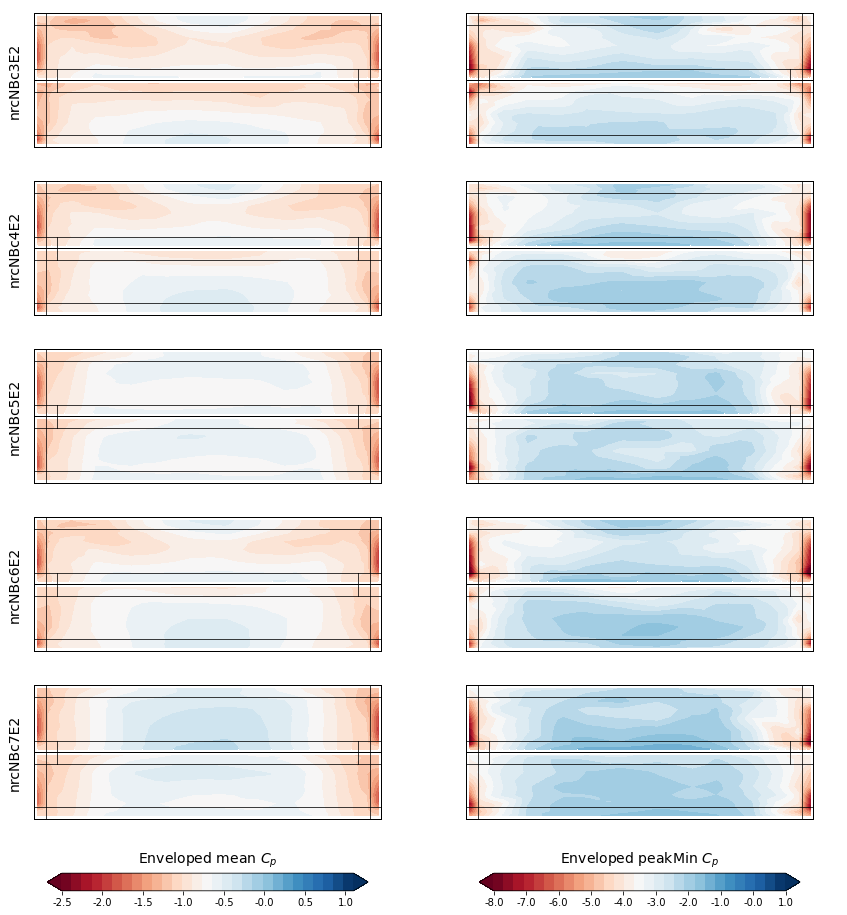

In [68]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(6,2,figsize=[12,14])
ax_cbar1 = axs[5,0]
ax_cbar2 = axs[5,1]
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for i, cp in enumerate(cp_all_OP):

    # fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    cp.plotZones(ax=ax, showLegend=False, kwargs_Fill={'alpha':0.0}, kwargs_Edge={'color':'k', 'linewidth':0.5})
    ax.text(0.02, 0.5, cp.name, transform=ax.transAxes, ha='center', va='center', fontsize=14, rotation=90)
    ax.axis('equal')
    ax.axis('off')
    # cbar = fig.colorbar(im[0], ax=ax, orientation='vertical',aspect=20,shrink=0.5,pad=0.0)
    # cbar.set_label(fld+r" $C_p$", fontsize=14, rotation=270, labelpad=20)
    # cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))
    if i == 4:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        ax_cbar1.set_position(new_pos)

    # cbar.ax.tick_params(labeltop=True, top=True)
    # cbar.ax.set_ylabel('Label', rotation=270, labelpad=15)
    # cbar.ax.set_title('Title', rotation=270, pad=20)
    # if saveFigs:
    #     fig.savefig(figDir+f"{casedir_iso}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')


    fld, fldrange, ticks = 'peakMin', [-8., 1.], np.linspace(-8,1.0,10)

    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    cp.plotZones(ax=ax, showLegend=False, kwargs_Fill={'alpha':0.0}, kwargs_Edge={'color':'k', 'linewidth':0.5})
    ax.axis('equal')
    ax.axis('off')
    if i == 3:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        ax_cbar2.set_position(new_pos)
if saveFigs:
    fig.savefig(figDir+f"multispan_contours.svg",format='svg',dpi=1200, bbox_inches='tight')

#### Wind tunnel data

### $C_p$ Plots

#### Local pressure

In [25]:
# figs = cp.plotTapCpStatsPerAoA(xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.06),nCols=7, figsize=[20,20],mrkrs=['None','None','None'], fldRange=[-13,3])#,fields=['mean','std'])

# tapsToPlot=[101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
# figs, all_axes = cp_iso_OP.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
#                 xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.02),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
#                 legend_bbox_to_anchor=(0.5, 0.95))#,fields=['mean','std'])

# cp_iso_SU.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
#                 xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.02),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
#                 legend_bbox_to_anchor=(0.5, 0.95), figs=figs, all_axes=all_axes)#,fields=['mean','std'])

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


# Component and cladding load

## C&C pressure coefficients from codes

In [ ]:
directionalityFactor = 0.85

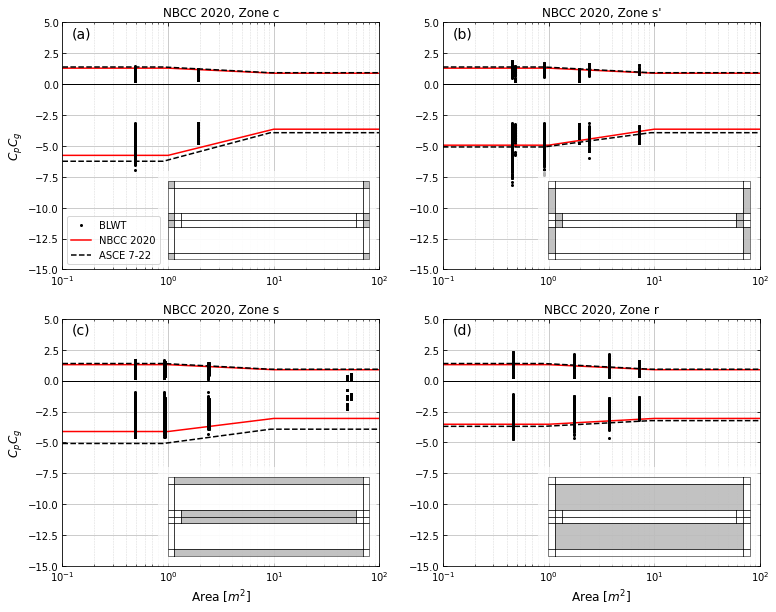

Saved figure: D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/multispan/__plots/CandC_Fig_E_iso.svg


In [93]:
fig = plt.figure(figsize=[12.5,10])
plt.tight_layout()

NumZones = bldg.NumZones
nCols = min(2, NumZones)
nRows = int(np.ceil(NumZones/nCols))
axs = fig.subplots(nRows, nCols, sharex=False, sharey=False)

for i, cp in enumerate(cp_all_OP):
    if i == 0:
        _, _ = cp.plotCandC_load(
                            fig=fig, axs=axs, 
                            # figSize=[12.5,10], sharex=False, sharey=False, nCols=2,
                            plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                            xLimits=[0.1,100], yLimits=[-18,5],
                            yLabel=r"$C_pC_g$",
                            label_min=r"BLWT", label_max=None,
                            kwargs_min={'color':'k', 'marker':'.', 'markersize':4,}, # 'linestyle':'-'},
                            kwargs_max={'color':'k', 'marker':'.', 'markersize':4,}, # 'linestyle':'-'},
                            overlayThese=[wind.NBCC2020_CpCg(Figure='4.1.7.6.-F', subfig='a'),  wind.ASCE7_22_GCp(Figure='30.3-4', subfig='a')],
                            overlayFactors=[1.0/directionalityFactor,                           (wind.getDurstFactor(3.0))**2],
                            # overlayThese=[wind.NBCC2020_CpCg(Figure='4.1.7.6.-F', subfig='a'), ],
                            # overlayFactors=[1.0/directionalityFactor,],
                            kwargs_overlay=({'color':'r',}, {'color':'k', 'linestyle':'--'}),
                            legend_ax_idx=0,
                            kwargs_legend={'loc':'right', 'fontsize':12},
                            subplotLabels=['(a)','(b)','(c)','(d)'], subplotLabels_xy=[0.03,0.94],
                            kwargs_ax={'gridMinor':True},
                            insetBounds=[0.3,0.0,0.7,0.4],
                            zoneShadeColor='darkgrey',
                            )
    else:
        _, _ = cp.plotCandC_load(
                            fig=fig, axs=axs, 
                            plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                            xLimits=[0.1,100], yLimits=[-18,5],
                            yLabel=r"$C_pC_g$",
                            label_min=None, label_max=None,
                            kwargs_min={'color':'k', 'marker':'.', 'markersize':4,}, # 'linestyle':'-'},
                            kwargs_max={'color':'k', 'marker':'.', 'markersize':4,}, # 'linestyle':'-'},
                            plotZoneGeom=False,
                            )
for I, zKey in enumerate(bldg.zoneDictKeys):
    i, j = np.unravel_index(I, axs.shape)
    ax = axs[i,j]
    ax.set_title(zKey)
    if i == axs.shape[0]-1:
        ax.set_xlabel(r'Area [$m^2$]')
    if j == 0:
        ax.set_ylabel(r"$C_pC_g$")
    ax.set_xlim([0.1,100])
    ax.set_ylim([-15,5])

    wind.formatAxis(ax, gridMinor=True)
plt.show()

if saveFigs:
    fig.savefig(figDir+"CandC_Fig_F.svg",format='svg',dpi=1200, bbox_inches='tight')
    print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")